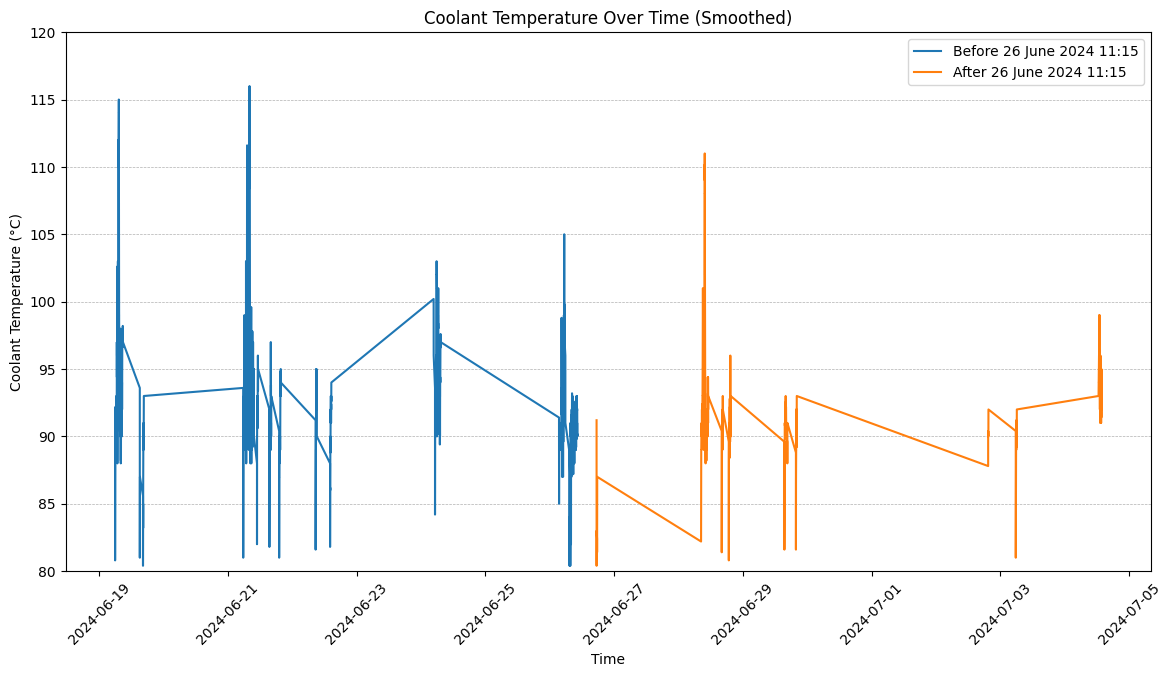

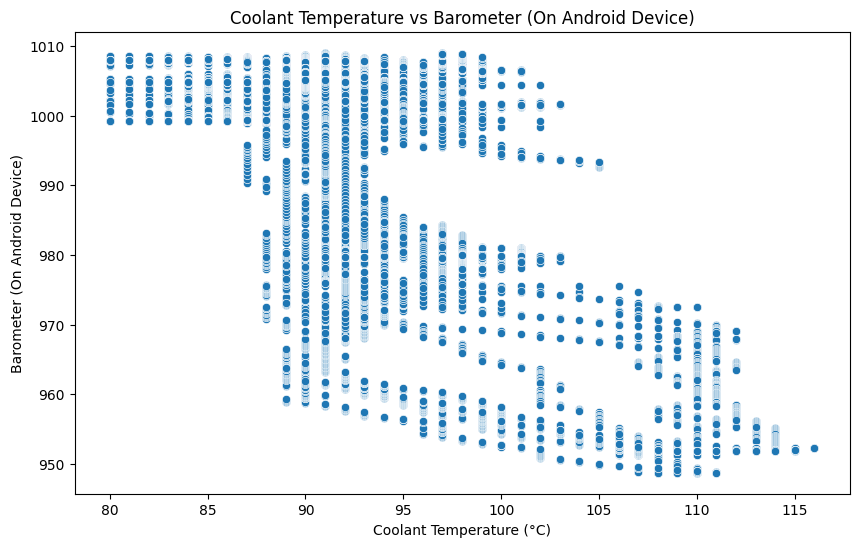

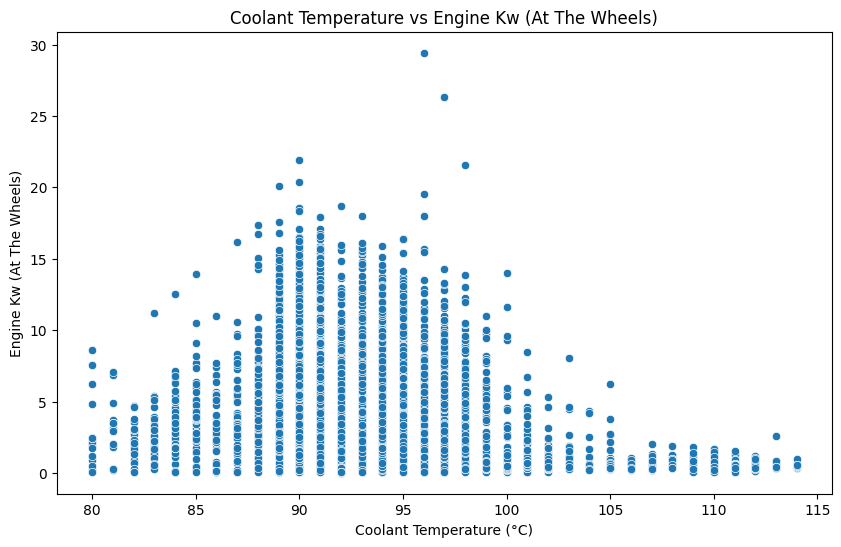

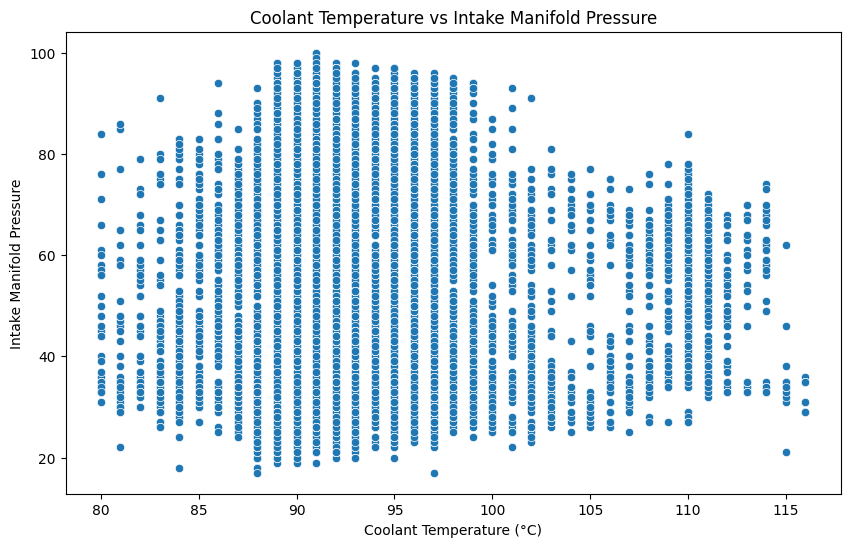

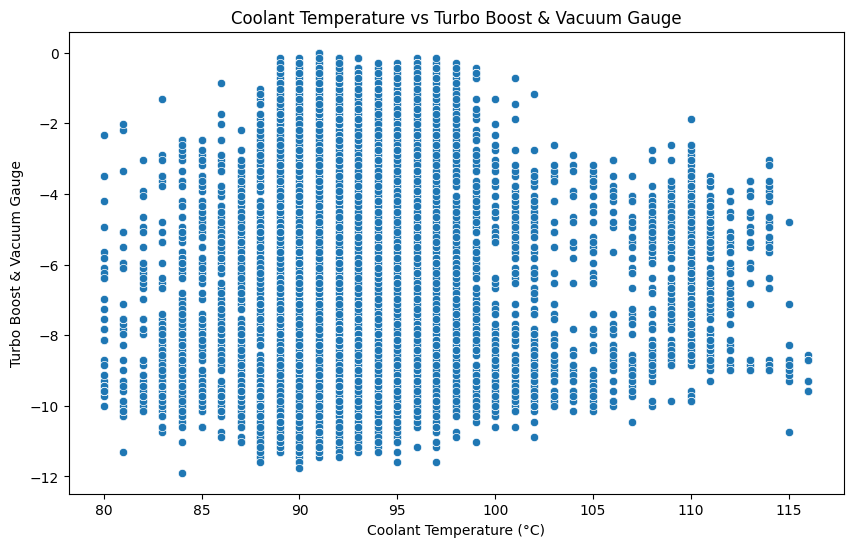

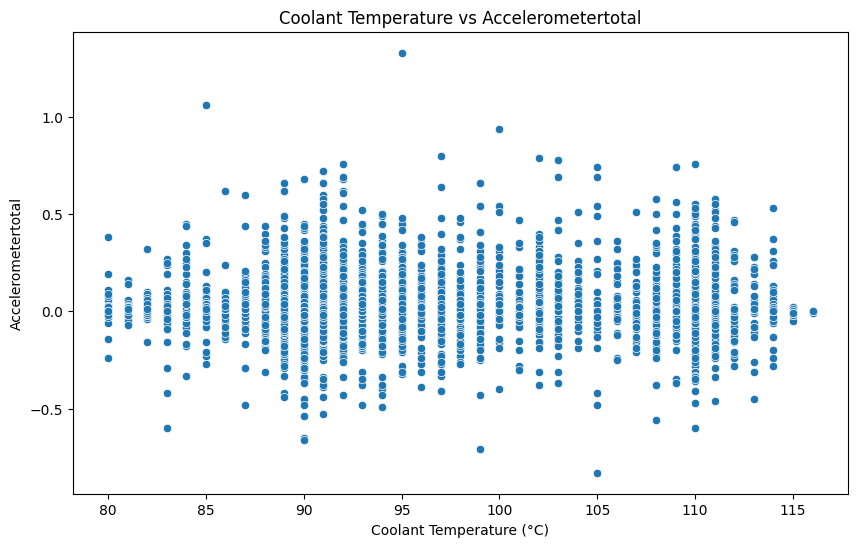

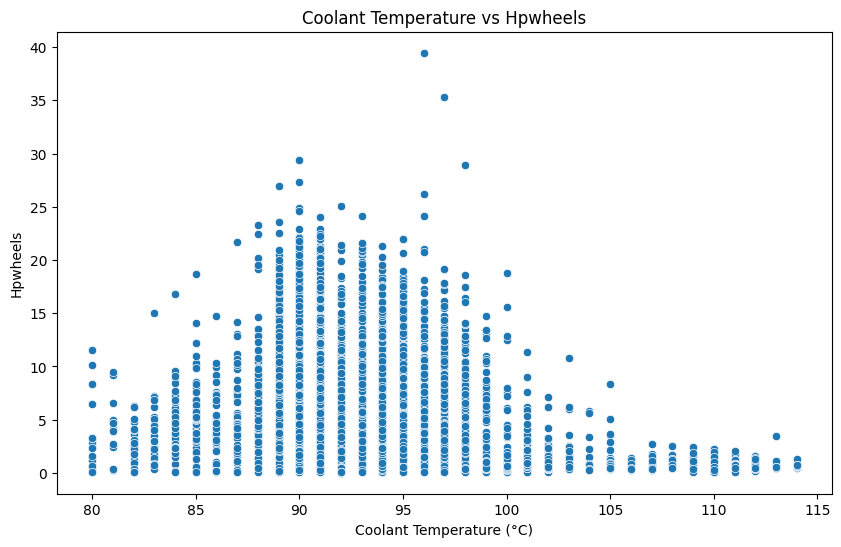

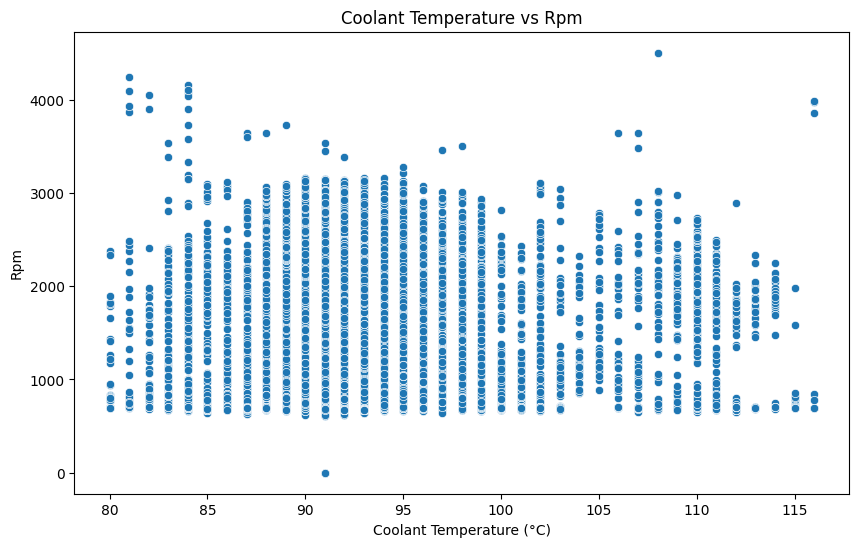

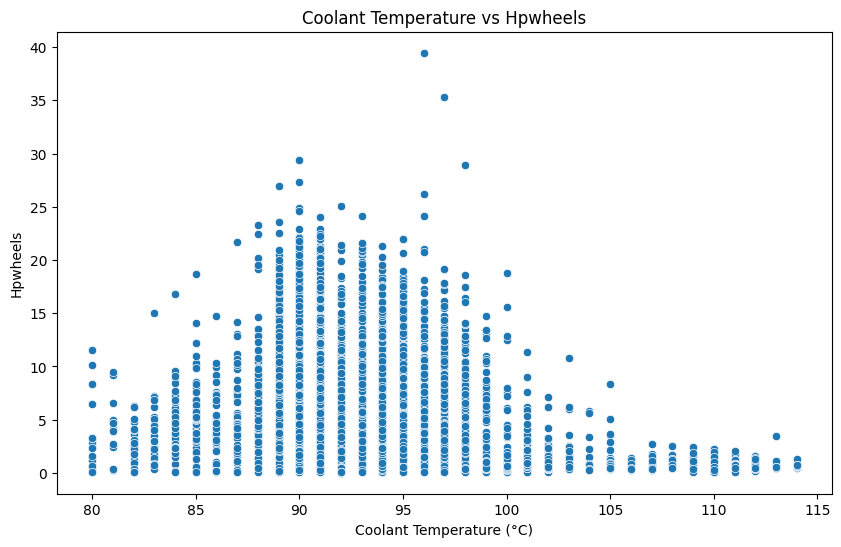

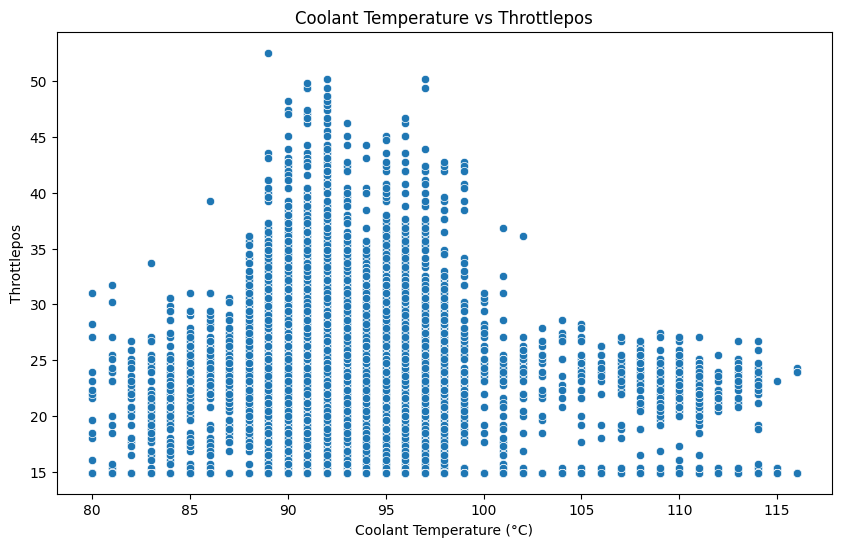

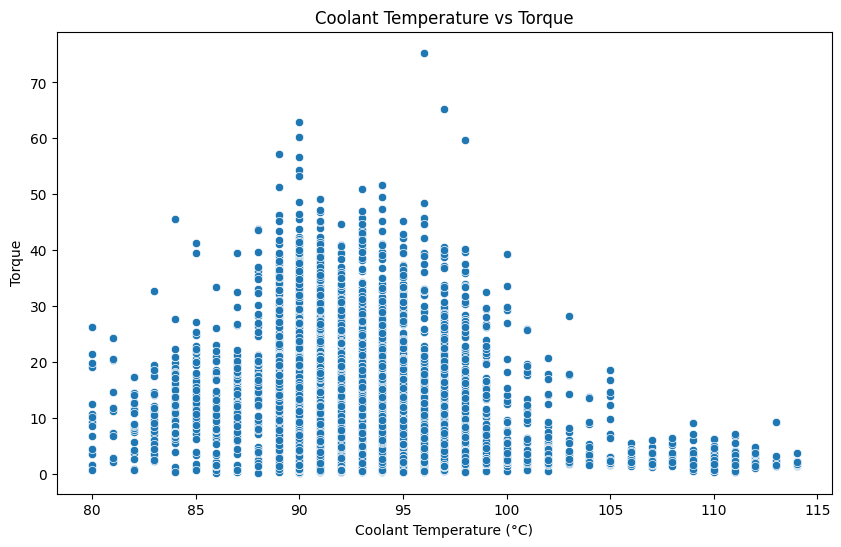

Driving Condition: offroad
Mean Before Fix: 95.84
Mean After Fix: 93.24
T-statistic: 13.48, P-value: 3.8711633180095006e-41
Effect Size (Cohen's d): -0.40
Mean difference: -2.60


Driving Condition: slow
Mean Before Fix: 92.95
Mean After Fix: 91.58
T-statistic: 8.81, P-value: 1.045616244082822e-18
Effect Size (Cohen's d): -0.33
Mean difference: -1.37


Driving Condition: urban
Mean Before Fix: 91.96
Mean After Fix: 90.09
T-statistic: 12.15, P-value: 3.343605567102929e-33
Effect Size (Cohen's d): -0.61
Mean difference: -1.88


Driving Condition: highway
Mean Before Fix: 91.04
Mean After Fix: 90.58
T-statistic: 6.38, P-value: 9.870308651908187e-11
Effect Size (Cohen's d): -0.26
Mean difference: -0.46




In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from scipy.stats import ttest_ind
import numpy as np

# Load the data
data = pd.read_csv('./influxdata_no_gps.csv')

# Convert the time column to datetime with UTC timezone
data['time'] = pd.to_datetime(data['time']).dt.tz_convert('UTC')

# Filter data to include only temperatures in the 80-120 range
data = data[(data['coolanttemp'] >= 80) & (data['coolanttemp'] <= 120)]

# Define the cutoff datetime with UTC timezone
cutoff = datetime(2024, 6, 26, 11, 15, tzinfo=pytz.UTC)

# Split the data into before and after the cutoff
before_cutoff = data[data['time'] < cutoff].copy()
after_cutoff = data[data['time'] >= cutoff].copy()

# Apply rolling mean to smooth out the curves, using a window of 5 (you can adjust this)
before_cutoff.loc[:, 'smooth_coolanttemp'] = before_cutoff['coolanttemp'].rolling(window=5).mean()
after_cutoff.loc[:, 'smooth_coolanttemp'] = after_cutoff['coolanttemp'].rolling(window=5).mean()

# Plotting the data
plt.figure(figsize=(14, 7))

# Plot before cutoff
sns.lineplot(x='time', y='smooth_coolanttemp', data=before_cutoff, label='Before 26 June 2024 11:15')

# Plot after cutoff
sns.lineplot(x='time', y='smooth_coolanttemp', data=after_cutoff, label='After 26 June 2024 11:15')

plt.title('Coolant Temperature Over Time (Smoothed)')
plt.xlabel('Time')
plt.ylabel('Coolant Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.ylim(80, 120)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

# List of other sensors to plot against coolant temperature
other_sensors = [
    'Barometer (on Android device)', 'Engine kW (At the wheels)', 'Intake Manifold Pressure','Turbo Boost & Vacuum Gauge',
    'accelerometertotal', 'hpwheels', 'rpm', 'hpwheels', 'throttlepos', 
    'torque'
]

# Plot scatter plots for each sensor against coolant temperature
for sensor in other_sensors:
    if sensor in data.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='coolanttemp', y=sensor, data=data)
        plt.title(f'Coolant Temperature vs {sensor.replace("_", " ").title()}')
        plt.xlabel('Coolant Temperature (°C)')
        plt.ylabel(sensor.replace("_", " ").title())
        plt.show()

# Define the driving conditions
def categorize_driving_condition(row):
    if row['speedobd'] <= 10:
        return 'offroad'
    elif row['speedobd'] > 10 and row['speedobd'] <= 30:
        return 'slow'
    elif row['speedobd'] > 30 and row['speedobd'] <= 60:
        return 'urban'
    else:
        return 'highway'

# Apply the categorization
data['driving_condition'] = data.apply(categorize_driving_condition, axis=1)
before_cutoff['driving_condition'] = before_cutoff.apply(categorize_driving_condition, axis=1)
after_cutoff['driving_condition'] = after_cutoff.apply(categorize_driving_condition, axis=1)

# Function to calculate statistics and perform tests
def analyze_condition(condition):
    before = before_cutoff[before_cutoff['driving_condition'] == condition]['coolanttemp']
    after = after_cutoff[after_cutoff['driving_condition'] == condition]['coolanttemp']
    
    mean_before = before.mean()
    mean_after = after.mean()
    std_before = before.std()
    std_after = after.std()
    
    t_stat, p_value = ttest_ind(before, after, alternative='greater')
    cohen_d = (mean_after - mean_before) / np.sqrt((std_before**2 + std_after**2) / 2)
    
    return mean_before, mean_after, t_stat, p_value, cohen_d

# Analyze each driving condition
conditions = ['offroad', 'slow', 'urban', 'highway']
results = {}

for condition in conditions:
    mean_before, mean_after, t_stat, p_value, cohen_d = analyze_condition(condition)
    results[condition] = {
        'mean_before': mean_before,
        'mean_after': mean_after,
        't_stat': t_stat,
        'p_value': p_value,
        'cohen_d': cohen_d
    }

# Print the results
for condition, result in results.items():
    print(f"Driving Condition: {condition}")
    print(f"Mean Before Fix: {result['mean_before']:.2f}")
    print(f"Mean After Fix: {result['mean_after']:.2f}")
    print(f"T-statistic: {result['t_stat']:.2f}, P-value: {result['p_value']}")
    print(f"Effect Size (Cohen's d): {result['cohen_d']:.2f}")
    print(f"Mean difference: {result['mean_after'] - result['mean_before']:.2f}")
    print('\n')